# TODO


- run on Gunjan's data
- Look into MSA

## Dependency imports

In [199]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import collections

from tensor2tensor import models
from tensor2tensor import problems
from tensor2tensor.layers import common_layers
from tensor2tensor.utils import trainer_lib
from tensor2tensor.utils import t2t_model
from tensor2tensor.utils import registry
from tensor2tensor.utils import metrics

# for loading in validation file
import pandas as pd

# for metrics
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import scipy
    
sys.path.append("../tfti")
import tfti

# Getting Required Files for Validation

/data/deepseavalidation.txt has been processed from valid.mat in the deepsea dataset. This is a raw text file of the data.

In [200]:
# TODO: user configures
tmp_dir = "/data/epitome/tmp/"
validation_file = os.path.join(tmp_dir, "deepsea_train/valid.mat")

if not os.path.isfile(validation_file):
     raise ValueError("%s cannot be found." % validation_file)
        

## Pipeline utility functions

In [227]:
##############################
#         HELPER FNS         #
##############################

def get_init_op():
    """Returns an initialization op."""
    global_init_op = tf.global_variables_initializer()
    local_init_op = tf.local_variables_initializer()
    return tf.group(global_init_op, local_init_op)

def get_session(is_interactive=True, **kwargs):
    """Returns a session."""
    config = tf.ConfigProto(
        log_device_placement=True,
        allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    if is_interactive:
        return tf.InteractiveSession(config=config, **kwargs)
    else:
        return tf.Session(config=config, **kwargs)

def restore_from_checkpoint(session, ckpt_dir=None):
    """Restores session from checkpoint."""
    if ckpt_dir is None:
        tf.logging.warn("Value for argument ckpt_dir is `None`. "
                        "Not restoring from checkpoint.")
    else:
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state(
            ckpt_dir).model_checkpoint_path
        saver.restore(session, ckpt)
        
def initialize_variables(session, ckpt_dir=None):
    """Initializes global and local variables."""
    init_op = get_init_op()
    session.run(init_op)
    restore_from_checkpoint(
        session=sess,
        ckpt_dir=ckpt_dir,
    )
    
def prepare_pipeline(problem_name,
                     model_name,
                     hparams_set,
                     hparams_overrides_str,
                     data_dir="None",
                     mode=tf.estimator.ModeKeys.EVAL):
    """Returns a tuple: (problem, model, hparams)."""
    problem = registry.problem(problem_name)
    problem.get_feature_encoders()  # Creates encoders.
    hparams = trainer_lib.create_hparams(
        hparams_set, hparams_overrides_str, data_dir, problem_name)
    model = registry.model(model_name)(hparams, mode)
    return problem, model, hparams

def get_latents_and_metrics_weights(problem, targets, keep_mask):
    """Creates latents and weights."""
    metrics_mask = tf.to_float(tf.logical_not(keep_mask))
    float_keep_mask = tf.to_float(keep_mask)
    latents = tf.to_int32(
        float_keep_mask * tf.to_float(targets)
        + (1.0 - float_keep_mask) * problem.unk_id)
    return latents, metrics_mask

def get_keep_mask_for_marks(mark_names, tf_names_indices):
    """
    Creates a keep mask, keeping the mark_names specified
    :param mark_names list of "Dnase, "CTCF", etc.
    :tf_names_indices ordered list of model label names
    """
    all_marks = list(map(lambda x: x[1].split("|")[1], tf_names_indices))
    return 1 * np.isin(all_marks, mark_names)
    
def get_raw_data_generator(validation_file, problem):
    """Yields raw inputs and targets.

    Yields:
        Tuples containing:
            inputs: NACTG strings of length 1000.
            targets: An binary label array of length 919.
    """
    # load in DEV data
    tmp = scipy.io.loadmat(validation_file)
    inputs = tmp["validxdata"]
    targets = tmp["validdata"]
    for i in range(inputs.shape[0]):
        yield problem.stringify(inputs[i].transpose([1, 0])), targets[i]
    

## Main body call

* Redefine the `get_raw_data_generator` to yield raw inputs.
* Also define `keep_mask` for deterministic masking/imputations.

In [216]:

def get_predictions_for_cell_type(validation_marks, dev_cell_type_1, dev_cell_type_2):
    # Reset graph for consistency.
    tf.reset_default_graph()

    # Construct pipeline.
    problem, model, hparams = prepare_pipeline(
        problem_name, model_name, hparams_set, hparams_overrides_str)


    # Shapes for preprocessed inputs/targets/latents.
    preprocessed_input_sequence_length = int(np.ceil(problem.input_sequence_length / problem.chunk_size))
    preprocessed_num_binary_predictions = len(problem.targets_gather_indices(dev_cell_type_1, dev_cell_type_2))
    targets_gather_indices = problem.targets_gather_indices (dev_cell_type_1, dev_cell_type_2) # testing on new cell type
    tf_names_indices = problem.get_overlapping_indices_for_cell_type(dev_cell_type_1, dev_cell_type_2)[1]

    # get mask based on chosen marks
    keep_mask = get_keep_mask_for_marks(validation_marks, tf_names_indices)

    def get_processed_data_generator_fn(raw_data_generator, keep_mask):
        # Reshape to rank 3 arrays/tensors.
        keep_mask = keep_mask.reshape([-1, 1, 1])
        def get_processed_data_generator():
            for raw_inputs, raw_targets in raw_data_generator:
                preprocessed_inputs = np.array(problem._encoders["inputs"].encode(raw_inputs), dtype=np.int64)
                preprocessed_targets = raw_targets[targets_gather_indices]
                # Reshape to rank 3 arrays/tensors.
                preprocessed_inputs = preprocessed_inputs.reshape([-1, 1, 1])
                preprocessed_targets = preprocessed_targets.reshape([-1, 1, 1])
                yield preprocessed_inputs, preprocessed_targets, keep_mask
        return get_processed_data_generator

    # Create dataset from generator.
    raw_data_generator = get_raw_data_generator(validation_file, problem)
    processed_data_generator_fn = get_processed_data_generator_fn(raw_data_generator, keep_mask)
    ds = tf.data.Dataset.from_generator(
        processed_data_generator_fn,
        output_types=(tf.int64, tf.int64, tf.bool),
        output_shapes=(
            [preprocessed_input_sequence_length, 1, 1],
            [preprocessed_num_binary_predictions, 1, 1],
            [preprocessed_num_binary_predictions, 1, 1],
        )
    )

    ds = ds.repeat(1)  # Single evaluation epoch.
    ds = ds.batch(batch_size)

    # Create one-shot-iterator.
    next_item = ds.make_one_shot_iterator().get_next()
    preprocessed_inputs, preprocessed_targets, latents_keep_mask = next_item

    # Create the latents from the targets and mask.
    latents, metrics_mask = get_latents_and_metrics_weights(problem, preprocessed_targets, latents_keep_mask)

    # Pass preprocessed features through model.
    preprocessed_features = {
        "inputs": preprocessed_inputs,
        "targets": preprocessed_targets,
        "latents": latents,
        "metrics_mask": metrics_mask,
    }

    logits, losses = model(preprocessed_features)
    predictions = tf.nn.sigmoid(logits)
    labels = preprocessed_features["targets"]

    # Evaluation metrics we want to use.
    set_auroc, _ = tfti.set_auroc(logits, labels, preprocessed_features)
    set_auprc, _ = tfti.set_auprc(logits, labels, preprocessed_features)
    average_auroc, _ = tfti.average_auroc(logits, labels, preprocessed_features)
    average_auprc, _ = tfti.average_auprc(logits, labels, preprocessed_features)

    # Initialize weights - randomly or from checkpoint
    sess = get_session(is_interactive=False)
    initialize_variables(sess, ckpt_dir)

    predictions_and_labels = []
    try:
        while True:
            # average_auroc updates a numerator & denominator
            # and computes the average_auroc for the entire dataset.
#             fetch = (predictions, labels)
#             fetch_numpy = sess.run(fetch) 
#             predictions_and_labels.append(fetch_numpy)
            final_average_auroc = sess.run(average_auroc)
        
#     predictions_and_labels = [(x.squeeze(), y.squeeze())
#                           for (x, y) in predictions_and_labels]
    except tf.errors.OutOfRangeError:
        print(f"Computed predictions for : {len(predictions_and_labels)} points")


#     predictions_numpy = np.array(predictions_and_labels)[:, 0, :]
#     labels_numpy = np.array(predictions_and_labels)[:, 1, :]
    
    return predictions_and_labels 

# ROC plots on all TFs for H1-hESC

In [222]:
# Parameters
problem_name="genomics_binding_deepsea_gm12878"
model_name="tfti_transformer"
hparams_set="tfti_transformer_base" 
hparams_overrides_str="batch_size=32,num_encoder_layers=6,num_decoder_layers=6,learning_rate_constant=0.2,latent_keep_prob=0.50,pos_weight=25" 
ckpt_dir=None  # No checkpoint.
batch_size=2  # For batch parallelism. TODO this is not efficient

In [223]:

# dev_cell_type_1 should be the cell type that you are evaluating against.
dev_cell_type_1 = 'GM12878'
dev_cell_type_2 = 'H1-hESC'

# define which marks you would like to keep in the mask
validation_marks = []

In [224]:
predictions_and_labels = get_predictions_for_cell_type(validation_marks, dev_cell_type_1, dev_cell_type_2)

INFO:tensorflow:Overriding hparams in tfti_transformer_base with batch_size=32,num_encoder_layers=6,num_decoder_layers=6,learning_rate_constant=0.2,latent_keep_prob=0.50,pos_weight=25


[2018-04-26 11:56:40,335] Overriding hparams in tfti_transformer_base with batch_size=32,num_encoder_layers=6,num_decoder_layers=6,learning_rate_constant=0.2,latent_keep_prob=0.50,pos_weight=25


INFO:tensorflow:Unsetting shared_embedding_and_softmax_weights.


[2018-04-26 11:56:40,339] Unsetting shared_embedding_and_softmax_weights.


INFO:tensorflow:Setting T2TModel mode to 'eval'


[2018-04-26 11:56:40,340] Setting T2TModel mode to 'eval'


INFO:tensorflow:Setting hparams.dropout to 0.0


[2018-04-26 11:56:40,342] Setting hparams.dropout to 0.0


INFO:tensorflow:Setting hparams.layer_prepostprocess_dropout to 0.0


[2018-04-26 11:56:40,343] Setting hparams.layer_prepostprocess_dropout to 0.0


INFO:tensorflow:Setting hparams.symbol_dropout to 0.0


[2018-04-26 11:56:40,344] Setting hparams.symbol_dropout to 0.0


INFO:tensorflow:Setting hparams.attention_dropout to 0.0


[2018-04-26 11:56:40,346] Setting hparams.attention_dropout to 0.0


INFO:tensorflow:Setting hparams.relu_dropout to 0.0


[2018-04-26 11:56:40,347] Setting hparams.relu_dropout to 0.0


INFO:tensorflow:Marks for CellType GM12878: [(204, 'GM12878|ATF2|None'), (205, 'GM12878|ATF3|None'), (207, 'GM12878|BCL11A|None'), (410, 'GM12878|BRCA1|None'), (210, 'GM12878|CEBPB|None'), (412, 'GM12878|CHD1|None'), (413, 'GM12878|CHD2|None'), (127, 'GM12878|CTCF|None'), (53, 'GM12878|DNase|None'), (128, 'GM12878|EZH2|None'), (212, 'GM12878|Egr-1|None'), (216, 'GM12878|GABP|None'), (420, 'GM12878|JunD|None'), (421, 'GM12878|Max|None'), (423, 'GM12878|Mxi1|None'), (223, 'GM12878|NRSF|None'), (428, 'GM12878|Nrf1|None'), (229, 'GM12878|Pol2-4H8|None'), (230, 'GM12878|Pol2|None'), (436, 'GM12878|RFX5|None'), (235, 'GM12878|RXRA|None'), (233, 'GM12878|Rad21|None'), (437, 'GM12878|SIN3A|None'), (236, 'GM12878|SIX5|None'), (237, 'GM12878|SP1|None'), (238, 'GM12878|SRF|None'), (240, 'GM12878|TAF1|None'), (442, 'GM12878|TBP|None'), (241, 'GM12878|TCF12|None'), (243, 'GM12878|USF-1|None'), (444, 'GM12878|USF2|None'), (244, 'GM12878|YY1|None'), (447, 'GM12878|Znf143|None'), (725, 'GM12878|c-Myc|

[2018-04-26 11:56:40,370] Marks for CellType GM12878: [(204, 'GM12878|ATF2|None'), (205, 'GM12878|ATF3|None'), (207, 'GM12878|BCL11A|None'), (410, 'GM12878|BRCA1|None'), (210, 'GM12878|CEBPB|None'), (412, 'GM12878|CHD1|None'), (413, 'GM12878|CHD2|None'), (127, 'GM12878|CTCF|None'), (53, 'GM12878|DNase|None'), (128, 'GM12878|EZH2|None'), (212, 'GM12878|Egr-1|None'), (216, 'GM12878|GABP|None'), (420, 'GM12878|JunD|None'), (421, 'GM12878|Max|None'), (423, 'GM12878|Mxi1|None'), (223, 'GM12878|NRSF|None'), (428, 'GM12878|Nrf1|None'), (229, 'GM12878|Pol2-4H8|None'), (230, 'GM12878|Pol2|None'), (436, 'GM12878|RFX5|None'), (235, 'GM12878|RXRA|None'), (233, 'GM12878|Rad21|None'), (437, 'GM12878|SIN3A|None'), (236, 'GM12878|SIX5|None'), (237, 'GM12878|SP1|None'), (238, 'GM12878|SRF|None'), (240, 'GM12878|TAF1|None'), (442, 'GM12878|TBP|None'), (241, 'GM12878|TCF12|None'), (243, 'GM12878|USF-1|None'), (444, 'GM12878|USF2|None'), (244, 'GM12878|YY1|None'), (447, 'GM12878|Znf143|None'), (725, 'GM12

INFO:tensorflow:Marks for CellType GM12878: [(204, 'GM12878|ATF2|None'), (205, 'GM12878|ATF3|None'), (207, 'GM12878|BCL11A|None'), (410, 'GM12878|BRCA1|None'), (210, 'GM12878|CEBPB|None'), (412, 'GM12878|CHD1|None'), (413, 'GM12878|CHD2|None'), (127, 'GM12878|CTCF|None'), (53, 'GM12878|DNase|None'), (128, 'GM12878|EZH2|None'), (212, 'GM12878|Egr-1|None'), (216, 'GM12878|GABP|None'), (420, 'GM12878|JunD|None'), (421, 'GM12878|Max|None'), (423, 'GM12878|Mxi1|None'), (223, 'GM12878|NRSF|None'), (428, 'GM12878|Nrf1|None'), (229, 'GM12878|Pol2-4H8|None'), (230, 'GM12878|Pol2|None'), (436, 'GM12878|RFX5|None'), (235, 'GM12878|RXRA|None'), (233, 'GM12878|Rad21|None'), (437, 'GM12878|SIN3A|None'), (236, 'GM12878|SIX5|None'), (237, 'GM12878|SP1|None'), (238, 'GM12878|SRF|None'), (240, 'GM12878|TAF1|None'), (442, 'GM12878|TBP|None'), (241, 'GM12878|TCF12|None'), (243, 'GM12878|USF-1|None'), (444, 'GM12878|USF2|None'), (244, 'GM12878|YY1|None'), (447, 'GM12878|Znf143|None'), (725, 'GM12878|c-Myc|

[2018-04-26 11:56:40,390] Marks for CellType GM12878: [(204, 'GM12878|ATF2|None'), (205, 'GM12878|ATF3|None'), (207, 'GM12878|BCL11A|None'), (410, 'GM12878|BRCA1|None'), (210, 'GM12878|CEBPB|None'), (412, 'GM12878|CHD1|None'), (413, 'GM12878|CHD2|None'), (127, 'GM12878|CTCF|None'), (53, 'GM12878|DNase|None'), (128, 'GM12878|EZH2|None'), (212, 'GM12878|Egr-1|None'), (216, 'GM12878|GABP|None'), (420, 'GM12878|JunD|None'), (421, 'GM12878|Max|None'), (423, 'GM12878|Mxi1|None'), (223, 'GM12878|NRSF|None'), (428, 'GM12878|Nrf1|None'), (229, 'GM12878|Pol2-4H8|None'), (230, 'GM12878|Pol2|None'), (436, 'GM12878|RFX5|None'), (235, 'GM12878|RXRA|None'), (233, 'GM12878|Rad21|None'), (437, 'GM12878|SIN3A|None'), (236, 'GM12878|SIX5|None'), (237, 'GM12878|SP1|None'), (238, 'GM12878|SRF|None'), (240, 'GM12878|TAF1|None'), (442, 'GM12878|TBP|None'), (241, 'GM12878|TCF12|None'), (243, 'GM12878|USF-1|None'), (444, 'GM12878|USF2|None'), (244, 'GM12878|YY1|None'), (447, 'GM12878|Znf143|None'), (725, 'GM12

INFO:tensorflow:Marks for CellType GM12878: [(204, 'GM12878|ATF2|None'), (205, 'GM12878|ATF3|None'), (207, 'GM12878|BCL11A|None'), (410, 'GM12878|BRCA1|None'), (210, 'GM12878|CEBPB|None'), (412, 'GM12878|CHD1|None'), (413, 'GM12878|CHD2|None'), (127, 'GM12878|CTCF|None'), (53, 'GM12878|DNase|None'), (128, 'GM12878|EZH2|None'), (212, 'GM12878|Egr-1|None'), (216, 'GM12878|GABP|None'), (420, 'GM12878|JunD|None'), (421, 'GM12878|Max|None'), (423, 'GM12878|Mxi1|None'), (223, 'GM12878|NRSF|None'), (428, 'GM12878|Nrf1|None'), (229, 'GM12878|Pol2-4H8|None'), (230, 'GM12878|Pol2|None'), (436, 'GM12878|RFX5|None'), (235, 'GM12878|RXRA|None'), (233, 'GM12878|Rad21|None'), (437, 'GM12878|SIN3A|None'), (236, 'GM12878|SIX5|None'), (237, 'GM12878|SP1|None'), (238, 'GM12878|SRF|None'), (240, 'GM12878|TAF1|None'), (442, 'GM12878|TBP|None'), (241, 'GM12878|TCF12|None'), (243, 'GM12878|USF-1|None'), (444, 'GM12878|USF2|None'), (244, 'GM12878|YY1|None'), (447, 'GM12878|Znf143|None'), (725, 'GM12878|c-Myc|

[2018-04-26 11:56:40,409] Marks for CellType GM12878: [(204, 'GM12878|ATF2|None'), (205, 'GM12878|ATF3|None'), (207, 'GM12878|BCL11A|None'), (410, 'GM12878|BRCA1|None'), (210, 'GM12878|CEBPB|None'), (412, 'GM12878|CHD1|None'), (413, 'GM12878|CHD2|None'), (127, 'GM12878|CTCF|None'), (53, 'GM12878|DNase|None'), (128, 'GM12878|EZH2|None'), (212, 'GM12878|Egr-1|None'), (216, 'GM12878|GABP|None'), (420, 'GM12878|JunD|None'), (421, 'GM12878|Max|None'), (423, 'GM12878|Mxi1|None'), (223, 'GM12878|NRSF|None'), (428, 'GM12878|Nrf1|None'), (229, 'GM12878|Pol2-4H8|None'), (230, 'GM12878|Pol2|None'), (436, 'GM12878|RFX5|None'), (235, 'GM12878|RXRA|None'), (233, 'GM12878|Rad21|None'), (437, 'GM12878|SIN3A|None'), (236, 'GM12878|SIX5|None'), (237, 'GM12878|SP1|None'), (238, 'GM12878|SRF|None'), (240, 'GM12878|TAF1|None'), (442, 'GM12878|TBP|None'), (241, 'GM12878|TCF12|None'), (243, 'GM12878|USF-1|None'), (444, 'GM12878|USF2|None'), (244, 'GM12878|YY1|None'), (447, 'GM12878|Znf143|None'), (725, 'GM12

INFO:tensorflow:Using variable initializer: uniform_unit_scaling


[2018-04-26 11:56:40,454] Using variable initializer: uniform_unit_scaling


INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_782_512.bottom


[2018-04-26 11:56:40,514] Transforming feature 'inputs' with symbol_modality_782_512.bottom


INFO:tensorflow:Transforming feature 'latents' with binary_imputation_class_label_modality_512.bottom


[2018-04-26 11:56:40,649] Transforming feature 'latents' with binary_imputation_class_label_modality_512.bottom


INFO:tensorflow:Transforming 'targets' with binary_class_label_modality_512.targets_bottom


[2018-04-26 11:56:40,687] Transforming 'targets' with binary_class_label_modality_512.targets_bottom


INFO:tensorflow:Building model body


[2018-04-26 11:56:40,716] Building model body


INFO:tensorflow:Transforming body output with binary_class_label_modality_512.top


[2018-04-26 11:56:47,289] Transforming body output with binary_class_label_modality_512.top


AttributeError: 'NoneType' object has no attribute 'model_checkpoint_path'

In [221]:
final_average_auroc

0.4694264

In [206]:
tfs = list(map(lambda x: x[1].split('|')[1], tf_names_indices))

In [209]:
predictions_and_labels

[(array([0.78735423, 0.78735423, 0.78735423, 0.78735423, 0.78735423,
         0.78735423, 0.78735423, 0.78735423, 0.78735423, 0.78735423,
         0.78735423, 0.78735423, 0.78735423, 0.78735423, 0.78735423,
         0.78735423, 0.78735423, 0.78735423, 0.78735423, 0.78735423,
         0.78735423, 0.78735423, 0.78735423, 0.78735423, 0.78735423,
         0.78735423, 0.78735423, 0.78735423, 0.78735423, 0.78735423,
         0.78735423, 0.78735423, 0.7873541 , 0.7873541 , 0.7873541 ],
        dtype=float32),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
 (array([0.7841883, 0.7841883, 0.7841883, 0.7841883, 0.7841883, 0.7841883,
         0.7841883, 0.7841883, 0.7841883, 0.7841883, 0.7841883, 0.7841883,
         0.7841883, 0.7841883, 0.7841883, 0.7841883, 0.7841883, 0.7841883,
         0.7841883, 0.7841883, 0.7841883, 0.7841883, 0.7841883, 0.7841883,
         0.7841883, 0.7841883, 0.7841883, 0.7841883, 0.7841883, 0.

[2018-04-26 11:01:03,183] No handles with labels found to put in legend.
/data/akmorrow/anaconda2/envs/python36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


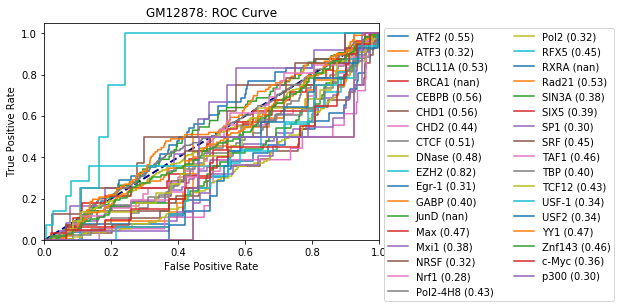

In [207]:
plt.figure()

lw = 2
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC Curve' % (dev_cell_type_1))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc='upper left', prop={'size':6}, bbox_to_anchor=(1,1))

for i in range(len(tfs)):
    tf_ = tfs[i]
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(labels_numpy[:,i], predictions_numpy[:,i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label='%s (%0.2f)' % (tf_, roc_auc))

plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=2)
plt.show()

# Precision Recall plots on all TFs for H1-hESC

[2018-04-26 11:01:31,795] No handles with labels found to put in legend.
/data/akmorrow/anaconda2/envs/python36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


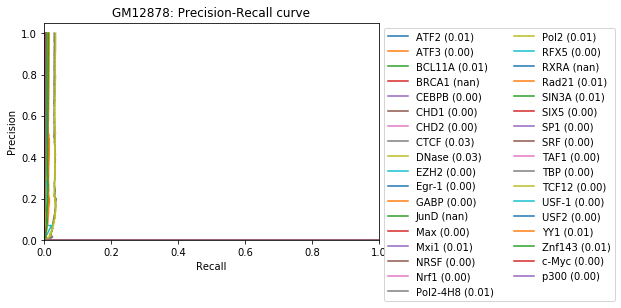

In [208]:
plt.figure()

lw = 2
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('%s: Precision-Recall curve' % (dev_cell_type_1))
plt.legend(loc='upper left', prop={'size':6}, bbox_to_anchor=(1,1))

for i in range(len(tfs)):
    tf_ = tfs[i]
    precision, recall, thresholds = precision_recall_curve(labels_numpy[:,i], predictions_numpy[:,i])
    auPRC = average_precision_score(labels_numpy[:,i], predictions_numpy[:,i])
    
    plt.plot(precision, recall, label='%s (%0.2f)' % (tf_, auPRC))

plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=2)
plt.show()



